In [21]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
import librosa.display
import librosa as lb
import soundfile as sf

import os

### Reading and Utilizing Provided Data

In [2]:
patient_data=pd.read_csv('data/patient_diagnosis.csv',names=['pid','disease'])

In [3]:
patient_data.head()

,pid,disease
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI


In [4]:
df=pd.read_csv('data/audio_and_txt_files/160_1b3_Al_mc_AKGC417L.txt',sep='\t')
df.head()

,1.862,5.718,0,1
0,5.718,9.725,1,1
1,9.725,13.614,0,1
2,13.614,17.671,0,1
3,17.671,19.541,0,0


(Start , End ( time of respiratory cycles) ,crackles,weezels)

In [5]:
path='data/audio_and_txt_files/'
files=[s.split('.')[0] for s in os.listdir(path) if '.txt' in s]
files[:5]

['148_1b1_Al_sc_Meditron',
 '130_3p2_Tc_mc_AKGC417L',
 '107_2b4_Al_mc_AKGC417L',
 '160_2b4_Pr_mc_AKGC417L',
 '174_1p4_Ar_mc_AKGC417L']

In [6]:
def getFilenameInfo(file):
    return file.split('_')

In [7]:
getFilenameInfo('160_1b3_Al_mc_AKGC417L')

['160', '1b3', 'Al', 'mc', 'AKGC417L']

[Patient ID, __ ,__ ,Type(mono,stereo), __ ]

In [8]:
files_data=[]
for file in files:
    data=pd.read_csv(path + file + '.txt',sep='\t',names=['start','end','crackles','weezels'])
    name_data=getFilenameInfo(file)
    data['pid']=name_data[0]
    data['mode']=name_data[-2]
    data['filename']=file
    files_data.append(data)
files_df=pd.concat(files_data)
files_df.reset_index()
files_df.head()

,start,end,crackles,weezels,pid,mode,filename
0,0.022,0.364,0,0,148,sc,148_1b1_Al_sc_Meditron
1,0.364,2.436,0,0,148,sc,148_1b1_Al_sc_Meditron
2,2.436,4.636,0,0,148,sc,148_1b1_Al_sc_Meditron
3,4.636,6.793,0,0,148,sc,148_1b1_Al_sc_Meditron
4,6.793,8.750,0,0,148,sc,148_1b1_Al_sc_Meditron


In [9]:
patient_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   pid      126 non-null    int64 
 1   disease  126 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.1+ KB


In [10]:
files_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6898 entries, 0 to 3
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   start     6898 non-null   float64
 1   end       6898 non-null   float64
 2   crackles  6898 non-null   int64  
 3   weezels   6898 non-null   int64  
 4   pid       6898 non-null   object 
 5   mode      6898 non-null   object 
 6   filename  6898 non-null   object 
dtypes: float64(2), int64(2), object(3)
memory usage: 431.1+ KB


In [11]:
patient_data.pid=patient_data.pid.astype('int32')
files_df.pid=files_df.pid.astype('int32')

In [12]:
data=pd.merge(files_df,patient_data,on='pid')
data.head()

,start,end,crackles,weezels,pid,mode,filename,disease
0,0.022,0.364,0,0,148,sc,148_1b1_Al_sc_Meditron,URTI
1,0.364,2.436,0,0,148,sc,148_1b1_Al_sc_Meditron,URTI
2,2.436,4.636,0,0,148,sc,148_1b1_Al_sc_Meditron,URTI
3,4.636,6.793,0,0,148,sc,148_1b1_Al_sc_Meditron,URTI
4,6.793,8.750,0,0,148,sc,148_1b1_Al_sc_Meditron,URTI


In [14]:
if not os.path.exists("data"):
    os.makedirs('data')

data.to_csv('data/data.csv',index=False)

### Processing Audio files

In [15]:
def getPureSample(raw_data,start,end,sr=22050):
    '''
    Takes a numpy array and spilts its using start and end args
    '''
    max_ind = len(raw_data) 
    start_ind = min(int(start * sr), max_ind)
    end_ind = min(int(end * sr), max_ind)
    return raw_data[start_ind: end_ind]

<AxesSubplot:ylabel='pid'>

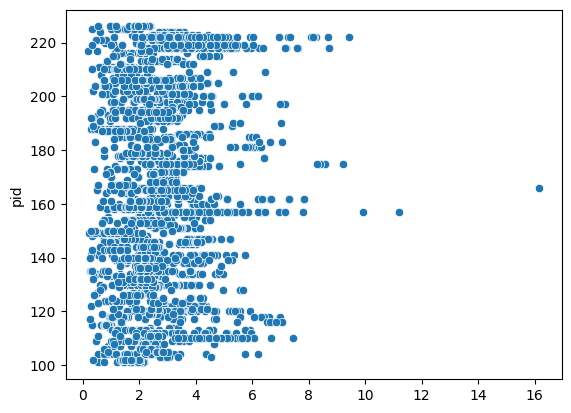

In [16]:
sns.scatterplot(x=(data.end-data.start), y=data.pid)

<AxesSubplot:>

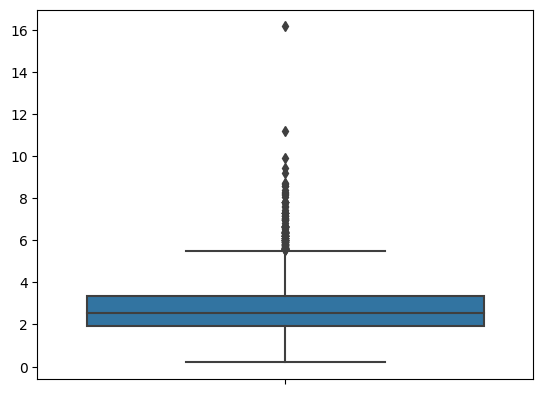

In [17]:
sns.boxplot(y=(data.end-data.start))

In [18]:
if not os.path.exists("data/processed_audio_files"):
    os.makedirs('data/processed_audio_files')

In [19]:
for index,row in data.iterrows():
    print("Index ->",index)
    print("Data->\n",row)
    break

Index -> 0
Data->
 start                        0.022
end                          0.364
crackles                         0
weezels                          0
pid                            148
mode                            sc
filename    148_1b1_Al_sc_Meditron
disease                       URTI
Name: 0, dtype: object


In [22]:

i,c=0,0
for index,row in data.iterrows():
    maxLen=6
    start=row['start']
    end=row['end']
    filename=row['filename']
    
    #If len > maxLen , change it to maxLen
    if end-start>maxLen:
        end=start+maxLen
    
    audio_file_loc=path + filename + '.wav'
    
    if index > 0:
        #check if more cycles exits for same patient if so then add i to change filename
        if data.iloc[index-1]['filename']==filename:
            i+=1
        else:
            i=0
    filename= filename + '_' + str(i) + '.wav'
    
    save_path='data/processed_audio_files/' + filename
    c+=1
    
    audioArr,sampleRate=lb.load(audio_file_loc)
    pureSample=getPureSample(audioArr,start,end,sampleRate)
    
    #pad audio if pureSample len < max_len
    reqLen=6*sampleRate
    padded_data = lb.util.pad_center(pureSample, reqLen)
    
    sf.write(file=save_path,data=padded_data,samplerate=sampleRate)
print('Total Files Processed: ',c)

/Users/admin/.pyenv/versions/3.7.16/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: Pass size=132300 as keyword args. From version 0.10 passing these as positional arguments will result in an error


Total Files Processed:  6898
